[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/atmos-cloud-sim-uj/PySDM.git/master?filepath=PySDM_examples/Yang_et_al_2018_Fig_2/demo.ipynb)    
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/atmos-cloud-sim-uj/PySDM/blob/master/PySDM_examples/Yang_et_al_2018_Fig_2/demo.ipynb)

#### based on Fig. 2 from Yang et al. 2018 (Atmos. Chem. Phys. 18)  "_Cloud droplet size distribution broadening during diffusional growth: ripening amplified by deactivation and reactivation_"   
https://doi.org/10.5194/acp-18-7313-2018

In [1]:
"""
clone and install PySDM dependencies in Colab
(to use GPU on Colab set hardware accelerator to 'GPU' before session start
in the "Runtime :: Change runtime type :: Hardware accelerator" menu)
"""
import os, sys
if 'google.colab' in sys.modules:
    %cd /content
    if not os.path.isdir('PySDM'):
        !git clone --depth 1 https://github.com/atmos-cloud-sim-uj/PySDM.git
        %cd PySDM
    else:
        %cd PySDM
        !git pull
    !pip --quiet install --requirement requirements.txt
    !ldconfig

In [2]:
import os, sys
if 'google.colab' in sys.modules:
    %cd /content/PySDM
else:
    sys.path.insert(0, os.path.join(os.getcwd(), '../..'))

In [3]:
from PySDM_tests.smoke_tests.utils import bdf
from PySDM_examples.Yang_et_al_2018_Fig_2.example import Simulation
from PySDM_examples.Yang_et_al_2018_Fig_2.settings import Settings
from PySDM.physics import formulae as phys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update({'font.size': 16})
from PySDM_examples.utils.show_plot import show_plot

In [4]:
import pint
si = pint.UnitRegistry()
si.setup_matplotlib()

In [5]:
ix51 = 40
ix503 = 99

In [6]:
schemes = ['default','non_adaptive', 'BDF']
#schemes = ['default']
# schemes = ['BDF']
rtol_bdf = 1e-4

In [9]:
def runner(scheme='BDF'):
    assert scheme in ['default','non_adaptive','BDF']
    settings = Settings(dt_output = 60*10*si.second)
    if scheme == 'non_adaptive':
        settings.adaptive = False
        settings.dt_max = .5 #* si.second
    
    assert round(settings.r_dry[  ix51]*1e9, 0) == 51
    assert round(settings.r_dry[ ix503]*1e9, 0) == 503

    simulation = Simulation(settings)
    if scheme == 'BDF':
        bdf.patch_core(simulation.core, settings.coord, rtol=rtol_bdf)
        
    output = simulation.run()
    result = {}
    
    result['r_bins_values'] = np.array(output['r_bins_values']).T / (settings.mass_of_dry_air)
    result['r_bins_edges'] = settings.r_bins_edges
    
    result['r'] = np.array(output['r']).T * si.metres
    result['t'] = output["t"] * si.seconds
    result['z'] = output["z"] * si.metres
    result['S'] = np.array(output["S"]) * si.dimensionless
    result['q'] = (settings.q0 - np.array(output["qv"])) * si.kilogram / si.kilogram
    result['T'] = np.array(output["T"])
    result['n'] = settings.n / (settings.mass_of_dry_air * si.kilogram)
    result['dt_max'] = settings.dt_max
    result['dt_cond_max'] = output['dt_cond_max']
    result['dt_cond_min'] = output['dt_cond_min']
    
    result['r_dry'] = settings.r_dry
    result['kappa'] = settings.kappa
    
    if scheme in ['default', 'non_adaptive']:
        result['rtol_x'] = settings.rtol_x
        result['rtol_thd'] = settings.rtol_thd
    if scheme == 'BDF':
        result['rtol_bdf'] = rtol_bdf
    
    arg_T = result['T'].reshape(-1,1).repeat(len(result['n']), axis = 1)
    result['r_cr'] = phys.r_cr(settings.kappa, settings.r_dry, arg_T).transpose()
    result['ripening_rate'] = output['ripening_rate']
    return  result

In [10]:
outputs = []
for scheme in schemes:
    outputs.append(runner(scheme))

In [11]:
figsize = (14, 9*len(outputs))

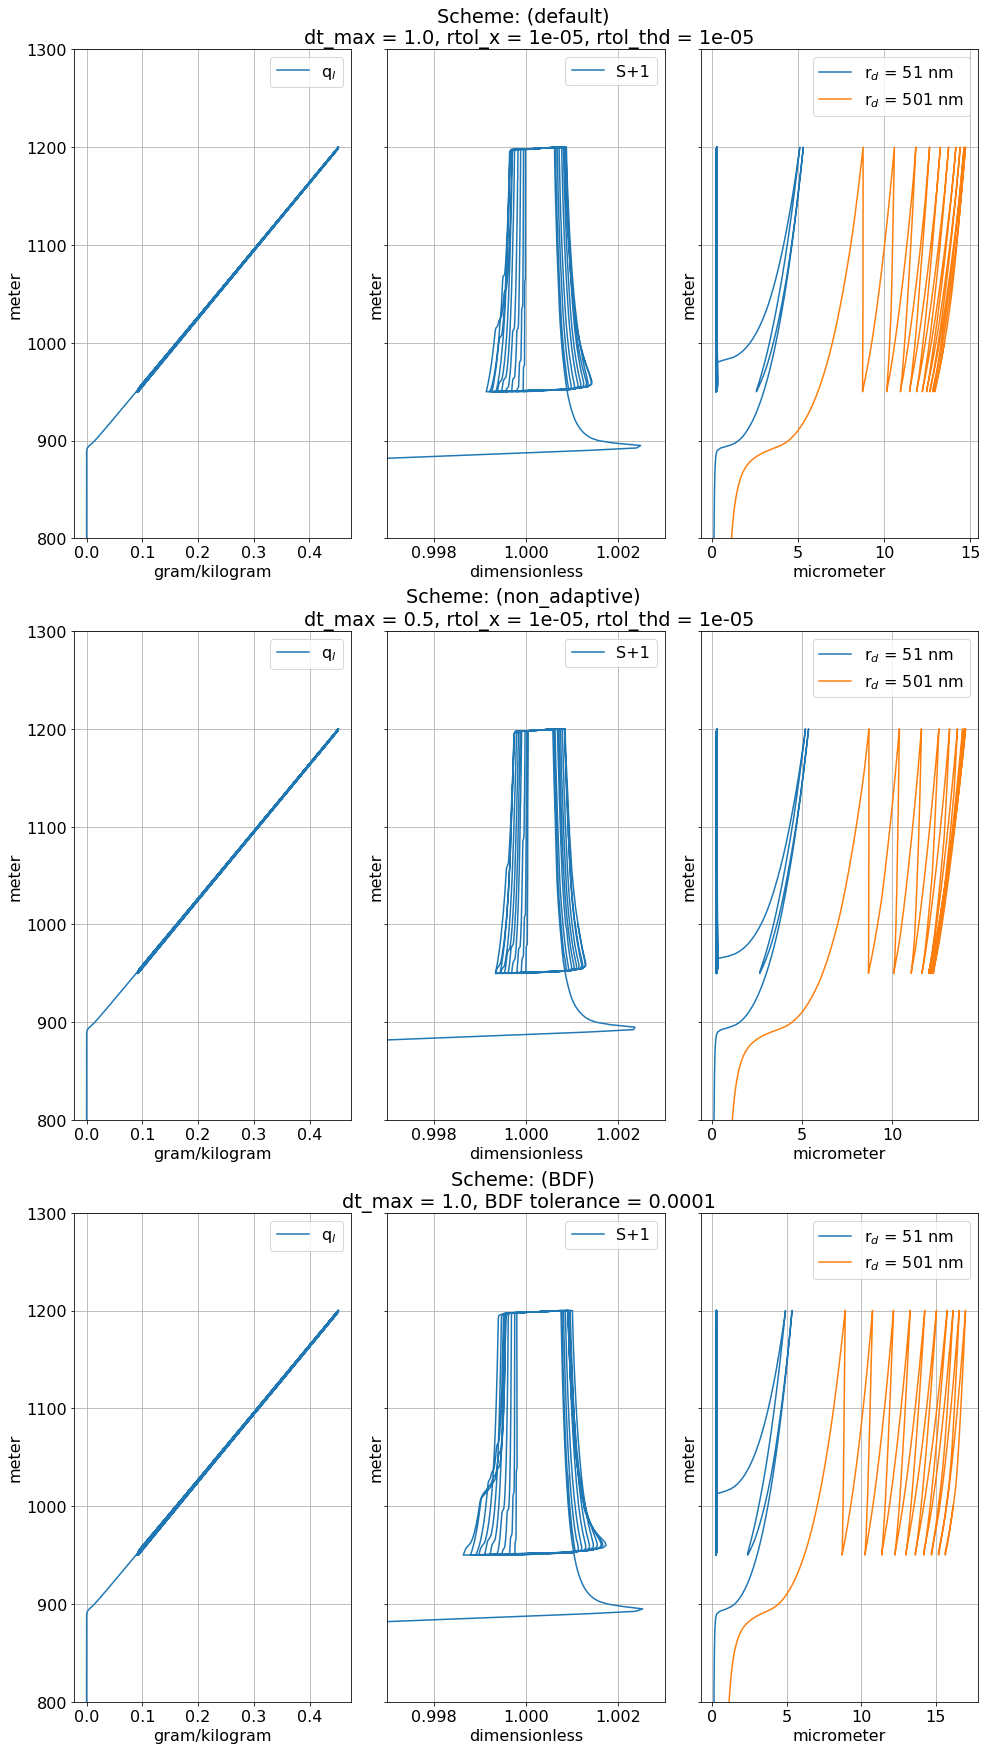

HTML(value="<a href='../utils/temporary_files/q_S_rd.pdf' target='_blank'>../utils/temporary_files/q_S_rd.pdf<…

In [12]:
fig, ax = plt.subplots(len(schemes), 3, sharey=True, figsize=figsize)
if len(outputs)==1:
    ax = np.array(ax).reshape(len(outputs),3)
for i, output in enumerate(outputs):
    dt_max = output['dt_max']
    if schemes[i]=='BDF':
        tols = f'BDF tolerance = {rtol_bdf}'
    else:
        rtol_x = output['rtol_x']
        rtol_thd = output['rtol_thd']
        tols = f'rtol_x = {rtol_x}, rtol_thd = {rtol_thd}'
        
    ax[i,1].set_title('Scheme: '+f'({schemes[i]}) \n dt_max = {dt_max}, '+tols)
    
    ax[i,0].set_ylim([800, 1300])
    ax[i,0].plot(output['q'], output['z'], label="q$_l$")
    ax[i,0].xaxis.set_units(si.gram / si.kilogram)
    ax[i,0].grid()
    ax[i,0].legend(loc='best')

    ax[i,1].plot(output['S']+1, output['z'], label="S+1")
    ax[i,1].grid()
    ax[i,1].legend(loc='best')
    ax[i,1].set_xlim([0.997, 1.003])

    ax[i,2].plot(output['r'][ix51], output['z'], label="r$_d$ = 51 nm")
    ax[i,2].plot(output['r'][ix503], output['z'], label="r$_d$ = 501 nm")
    ax[i,2].grid()
    ax[i,2].xaxis.set_units(si.micrometre)
    ax[i,2].legend(loc='best')
    plt.tight_layout()
    fig.subplots_adjust(top=0.88)

show_plot(filename='q_S_rd.pdf')

In [13]:
def rmean(r, n, mask): # TODO: move to products
    nt = r.shape[1]
    n_dot_r = n.magnitude.dot(np.where(mask, r.magnitude, 0))
    n_tot = np.sum(np.where(mask, n.magnitude.reshape(-1,1).repeat(nt, axis=1), 0), axis=0)
    rmean = np.full(nt, np.nan)
    nmask = n_tot > 0
    rmean[nmask] = n_dot_r[nmask] / n_tot[nmask]
    return rmean * r.units

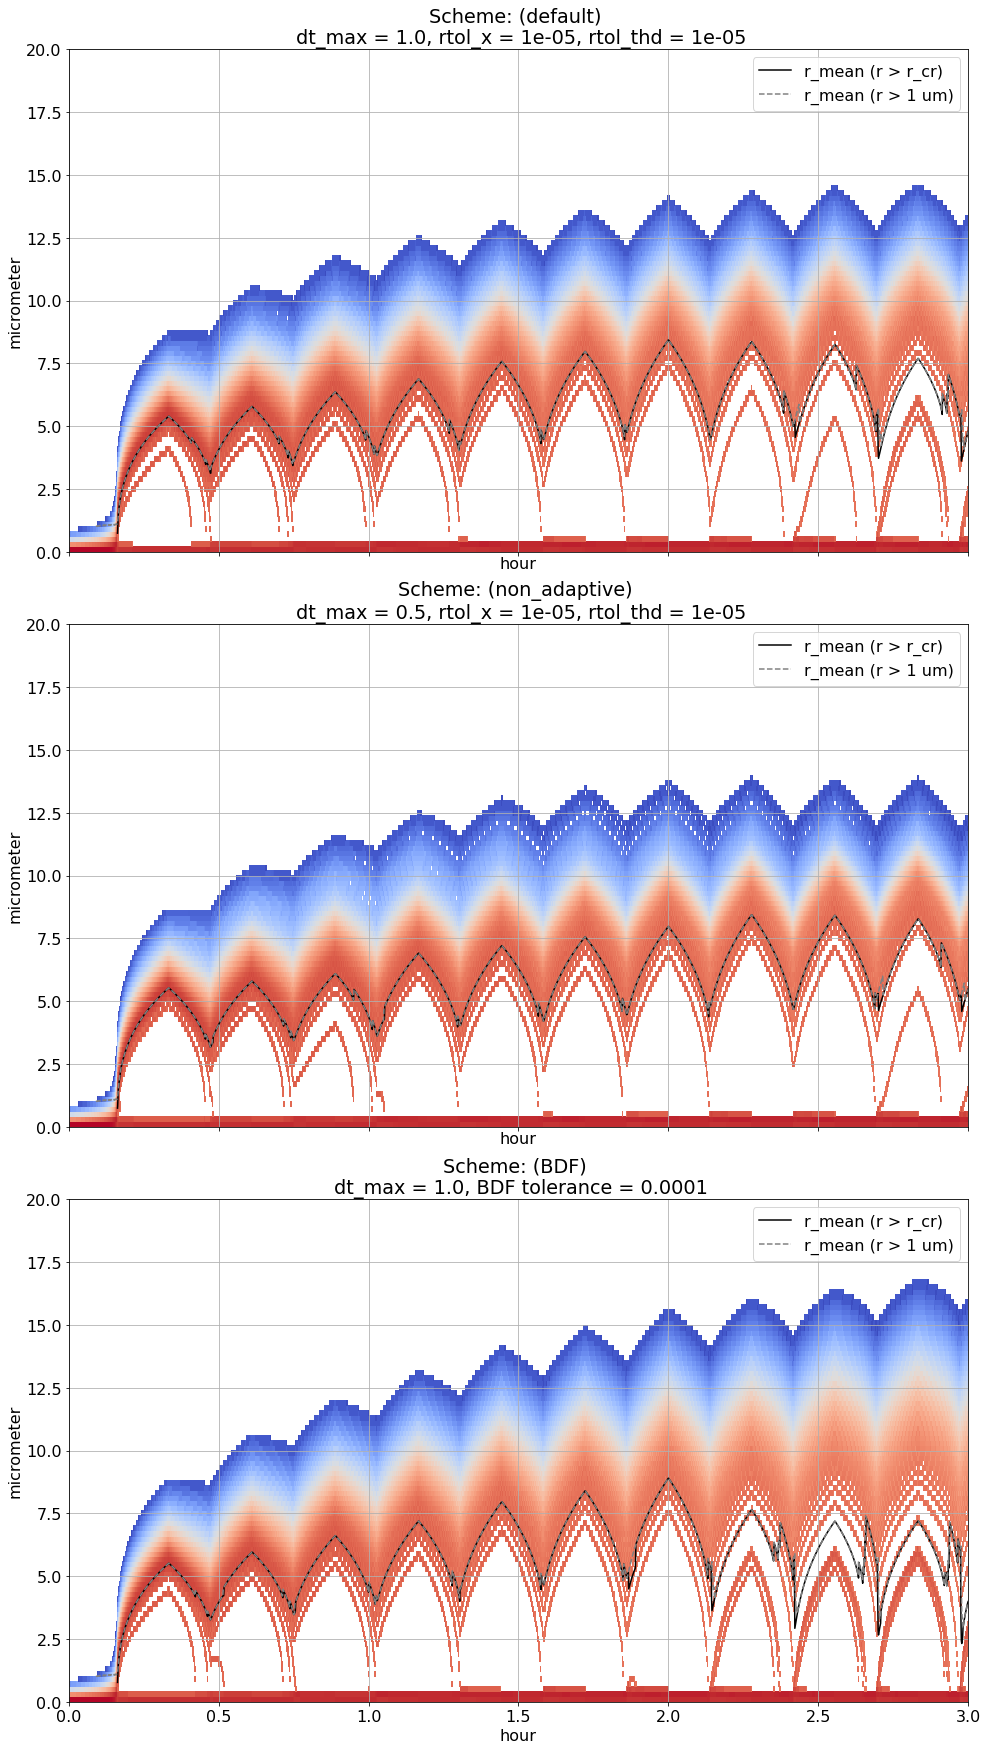

HTML(value="<a href='../utils/temporary_files/spectrum.pdf' target='_blank'>../utils/temporary_files/spectrum.…

In [14]:
mgn = lambda value, unit: (value / unit).to_base_units().magnitude

fig, ax = plt.subplots(len(schemes), 1, sharex=True, figsize=figsize)
if len(outputs)==1:
    ax = (ax,)
for i, output in enumerate(outputs):
    dt_max = output['dt_max']
    if i==2:
        rtol = output['rtol_bdf']
        tols = f'BDF tolerance = {rtol}'
    else:
        rtol_x = output['rtol_x']
        rtol_thd = output['rtol_thd']
        tols = f'rtol_x = {rtol_x}, rtol_thd = {rtol_thd}'
    
    hist = output['r_bins_values']
    hist = (hist[:,0:-1] + hist[:,1:])/2
    xedges = output['t'].magnitude
    yedges = output['r_bins_edges']
    
    xunit = si.hour
    yunit = si.micrometres

    c = ax[i].pcolormesh(
        mgn(xedges * output['t'].units, xunit), 
        mgn(yedges * output['r'].units, yunit), 
        hist,
        cmap = 'coolwarm', shading='auto',
        norm = mpl.colors.LogNorm()
    )
    ax[i].set_title('Scheme: '+f'({schemes[i]}) \n dt_max = {dt_max}, '+tols)
    ax[i].yaxis.set_units(yunit)
    ax[i].xaxis.set_units(xunit)
    ax[i].set_ylim([0, 20])

    ax[i].plot(output['t'], rmean(output['r'], output['n'], output['r'].magnitude > output['r_cr']), label="r_mean (r > r_cr)", color='black')
    ax[i].plot(output['t'], rmean(output['r'], output['n'], output['r'] > 1 * si.micrometre), label="r_mean (r > 1 um)", linestyle='--', color='gray')
    ax[i].legend(loc='best')
    ax[i].grid()
    plt.tight_layout()
    fig.subplots_adjust(top=0.88)
show_plot(filename='spectrum.pdf')